## 1. Install packages, GPU and Seed

In [1]:
# Standard libraries
import h5py
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.colors import ListedColormap
import matplotlib.colors as colors
import numpy as np
import pandas as pd
import random
import os
import pickle
import gc
from collections import Counter

# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader


# Sklearn
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

# Custom
from cust_functions.processing_helper import *
from cust_functions.models import *
from cust_functions.training_helper import *
from cust_functions.datavis_helper import *

In [2]:
print("Torch CUDA available:", torch.cuda.is_available())
print("Number of GPUs:", torch.cuda.device_count())
print("Current GPU:", torch.cuda.current_device())
print("GPU Name:", torch.cuda.get_device_name(torch.cuda.current_device()))

Torch CUDA available: True
Number of GPUs: 2
Current GPU: 0
GPU Name: NVIDIA GeForce GTX 1080 Ti


In [3]:
"""
Define seed
"""

SEED = 42

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = False
torch.backends.cudnn.benchmark = False

## 2. Validation set creation (Resuls are saved already)

In [4]:
directory = "/home"
base_path = f"{directory}/pf/pfstud/mlarriere/aligned_data/"
dw_path = f"{directory}/pf/pfstud/mlarriere/DW_files/DW_timeslices/"

tile_lengths = {'tile0': 36, 'tile1': 26, 'tile3': 16, 'tile4': 22}
tiles = [0, 1, 3, 4]

# create files for all h5 image tiles
tile0 = [f"{base_path}tile0_aligned_{timestep}.h5" for timestep in range(0, tile_lengths['tile0'])]
tile1 = [f"{base_path}tile1_aligned_{timestep}.h5" for timestep in range(0, tile_lengths['tile1'])]
tile3 = [f"{base_path}tile3_aligned_{timestep}.h5" for timestep in range(0, tile_lengths['tile3'])]
tile4 = [f"{base_path}tile4_aligned_{timestep}.h5" for timestep in range(0, tile_lengths['tile4'])]
h5_files = tile0 + tile1 + tile3 + tile4

# create files for all h5 land cover tiles
dw_tile0 = [f"{dw_path}scaled_cloudy_tile_0_dw_{timestep}.h5" for timestep in range(0, tile_lengths['tile0'])]
dw_tile1 = [f"{dw_path}scaled_cloudy_tile_1_dw_{timestep}.h5" for timestep in range(0, tile_lengths['tile1'])]
dw_tile3 = [f"{dw_path}scaled_cloudy_tile_3_dw_{timestep}.h5" for timestep in range(0, tile_lengths['tile3'])]
dw_tile4 = [f"{dw_path}scaled_cloudy_tile_4_dw_{timestep}.h5" for timestep in range(0, tile_lengths['tile4'])]
dw_files_scaled_cloudy = dw_tile0 + dw_tile1 + dw_tile3 + dw_tile4

h5_files_first_image = tile0[0:1] + tile1[0:1] + tile3[0:1] + tile4[0:1]
dw_files_first_image = dw_tile0[0:1] + dw_tile1[0:1] + dw_tile3[0:1] + dw_tile4[0:1]

In [ ]:
# 128 x 128 patches
file_names = {'CLD': 'CLD', 'RGB': 'RGB', 'NIR': 'NIR'}
dw_file_name = 'DW_cloudy'
dataset_first_image = H5Dataset(h5_files_first_image, dw_files_first_image, file_name = file_names, dw_file_name=dw_file_name, patch_size=(128, 128), cloud_threshold = 1.0, augment=False, num_augment=1)
dataset_full = H5Dataset(h5_files, dw_files_scaled_cloudy, file_name = file_names, dw_file_name=dw_file_name, patch_size=(128, 128), cloud_threshold = 1.0, augment=False, num_augment=1)

In [20]:
# 256 x 256 patches
file_names = {'CLD': 'CLD', 'RGB': 'RGB', 'NIR': 'NIR'}
dw_file_name = 'DW_cloudy'
dataset_first_image_256 = H5Dataset(h5_files_first_image, dw_files_first_image, file_name = file_names, dw_file_name=dw_file_name, patch_size=(256, 256), cloud_threshold = 1.0, augment=False, num_augment=1)
dataset_full_256 = H5Dataset(h5_files, dw_files_scaled_cloudy, file_name = file_names, dw_file_name=dw_file_name, patch_size=(256, 256), cloud_threshold = 1.0, augment=False, num_augment=1)

In [15]:
### 128 x 128 patches ###
train_size = int(0.9 * len(dataset_first_image ))
val_size = len(dataset_first_image) - train_size
train_dataset_single,  val_dataset_single = torch.utils.data.random_split(dataset_first_image , [train_size, val_size])

# Function to count labels in a dataset
def count_labels_in_batches(dataset):
    label_counter = Counter()
    for _, labels in dataset:
        flattened_labels = labels.flatten().numpy()
    return label_counter

labels_full = count_labels_in_batches(dataset_first_image)
labels_val = count_labels_in_batches(val_dataset_single)

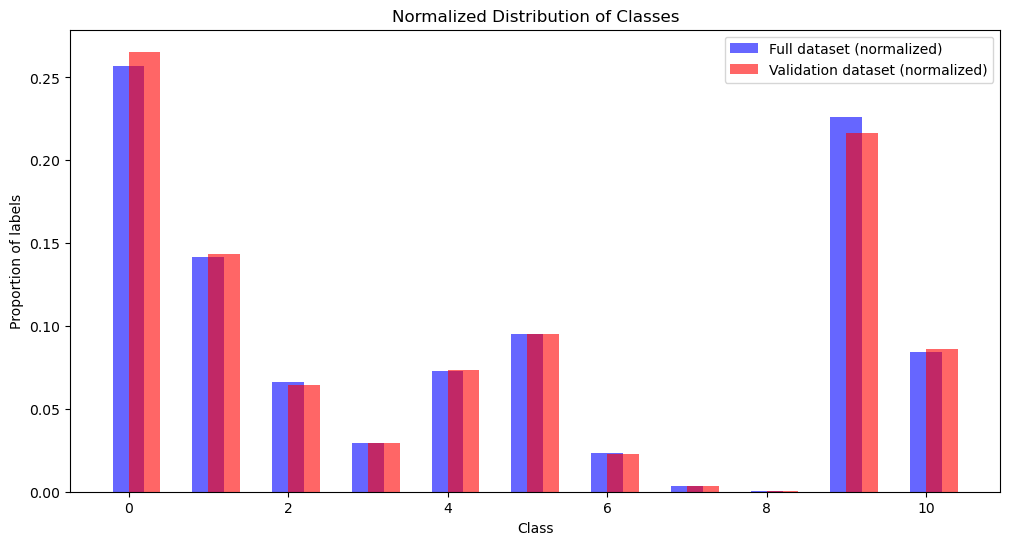

In [16]:
### 128 x 128 patches ###
total_full = sum(labels_full.values())
total_val = sum(labels_val.values())
labels_full_normalized = {k: v / total_full for k, v in labels_full.items()}
labels_val_normalized = {k: v / total_val for k, v in labels_val.items()}

plt.figure(figsize=(12, 6))
plt.bar(labels_full_normalized.keys(), labels_full_normalized.values(), width=0.4, align='center', alpha=0.6, color='b')
plt.bar(labels_val_normalized.keys(), labels_val_normalized.values(), width=0.4, align='edge', alpha=0.6, color='r')
plt.xlabel('Class')
plt.ylabel('Proportion of labels')
plt.legend(['Full dataset (normalized)', 'Validation dataset (normalized)'])
plt.title('Normalized Distribution of Classes')
plt.show()

In [ ]:
### 128 x 128 patches ###
train_size = int(0.9 * len(dataset_first_image ))
val_size = len(dataset_first_image) - train_size
train_dataset_single,  val_dataset_single = torch.utils.data.random_split(dataset_first_image , [train_size, val_size])

# get indices of patches that are used for training and validation
val_patch_starts_single = [dataset_first_image.get_patch_starts()[idx] for idx in val_dataset_single.indices]

val_patch_starts = []
for patch_start in val_patch_starts_single:
    if patch_start[0] == 0:
        val_patch_starts.extend([(idx, patch_start[1], patch_start[2]) for idx in range(0, tile_lengths['tile0'])])
    elif patch_start[0] == 1:
        val_patch_starts.extend([(idx, patch_start[1], patch_start[2]) for idx in range(tile_lengths['tile0'], tile_lengths['tile0'] + tile_lengths['tile1'])])
    elif patch_start[0] == 2:
        val_patch_starts.extend([(idx, patch_start[1], patch_start[2]) for idx in range(tile_lengths['tile0'] + tile_lengths['tile1'], tile_lengths['tile0'] + tile_lengths['tile1'] + tile_lengths['tile3'])])
    elif patch_start[0] == 3:
        val_patch_starts.extend([(idx, patch_start[1], patch_start[2]) for idx in range(tile_lengths['tile0'] + tile_lengths['tile1'] + tile_lengths['tile3'], tile_lengths['tile0'] + tile_lengths['tile1'] + tile_lengths['tile3'] + tile_lengths['tile4'])])

print(len(val_patch_starts))

val_indices = dataset_full.get_indices_based_on_patch_starts(val_patch_starts)
print(len(val_indices))
# save indices
with open('val_indices_128.pkl', 'wb') as f:
    pickle.dump(val_indices, f)


In [19]:
### 256 x 256 patches ###
train_size = int(0.9 * len(dataset_first_image_256 ))
val_size = len(dataset_first_image_256) - train_size
train_dataset_single,  val_dataset_single = torch.utils.data.random_split(dataset_first_image_256, [train_size, val_size], )

labels_full = count_labels_in_batches(dataset_first_image)
labels_val = count_labels_in_batches(val_dataset_single)

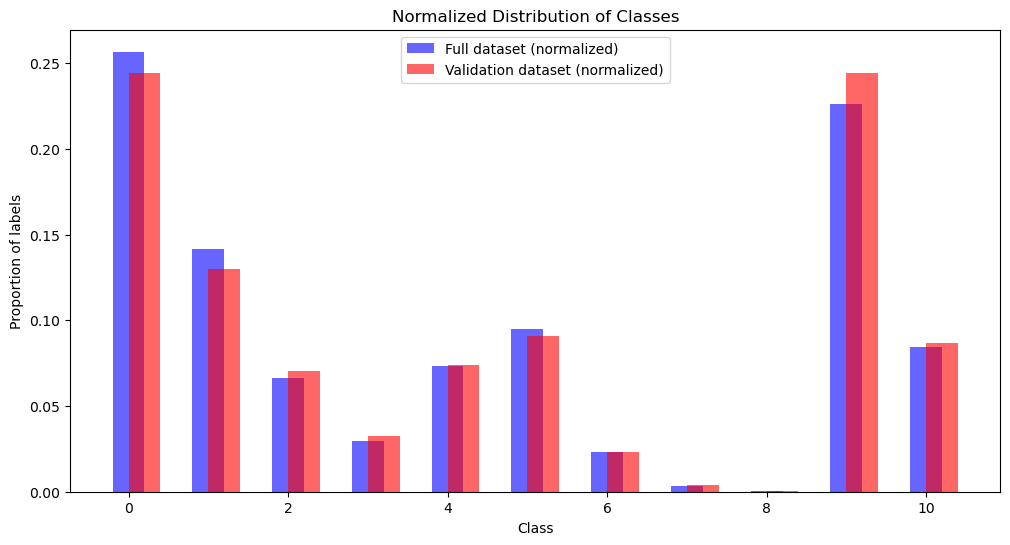

In [20]:
### 256 x 256 patches ###
total_full = sum(labels_full.values())
total_val = sum(labels_val.values())
labels_full_normalized = {k: v / total_full for k, v in labels_full.items()}
labels_val_normalized = {k: v / total_val for k, v in labels_val.items()}

plt.figure(figsize=(12, 6))
plt.bar(labels_full_normalized.keys(), labels_full_normalized.values(), width=0.4, align='center', alpha=0.6, color='b')
plt.bar(labels_val_normalized.keys(), labels_val_normalized.values(), width=0.4, align='edge', alpha=0.6, color='r')
plt.xlabel('Class')
plt.ylabel('Proportion of labels')
plt.legend(['Full dataset (normalized)', 'Validation dataset (normalized)'])
plt.title('Normalized Distribution of Classes')
plt.show()

In [ ]:
### 256 x 256 patches ###

# get indices of patches that are used for training and validation
val_patch_starts_single = [dataset_first_image_256.get_patch_starts()[idx] for idx in val_dataset_single.indices]

val_patch_starts = []
for patch_start in val_patch_starts_single:
    if patch_start[0] == 0:
        val_patch_starts.extend([(idx, patch_start[1], patch_start[2]) for idx in range(0, tile_lengths['tile0'])])
    elif patch_start[0] == 1:
        val_patch_starts.extend([(idx, patch_start[1], patch_start[2]) for idx in range(tile_lengths['tile0'], tile_lengths['tile0'] + tile_lengths['tile1'])])
    elif patch_start[0] == 2:
        val_patch_starts.extend([(idx, patch_start[1], patch_start[2]) for idx in range(tile_lengths['tile0'] + tile_lengths['tile1'], tile_lengths['tile0'] + tile_lengths['tile1'] + tile_lengths['tile3'])])
    elif patch_start[0] == 3:
        val_patch_starts.extend([(idx, patch_start[1], patch_start[2]) for idx in range(tile_lengths['tile0'] + tile_lengths['tile1'] + tile_lengths['tile3'], tile_lengths['tile0'] + tile_lengths['tile1'] + tile_lengths['tile3'] + tile_lengths['tile4'])])

print(len(val_patch_starts))

val_indices = dataset_full_256.get_indices_based_on_patch_starts(val_patch_starts)
print(len(val_indices))
# save indices
with open('val_indices_256.pkl', 'wb') as f:
    pickle.dump(val_indices, f)


In [8]:
with open('val_indices_128.pkl', 'rb') as f:
    val_indices = pickle.load(f)
    print(len(val_indices))

val_dataset_128 = torch.utils.data.Subset(dataset_full, val_indices)
save_dir = '/home/pf/pfstud/mlarriere/preprocessed_val_data_128'
save_preprocessed_data(val_dataset_128, save_dir)

47190


In [21]:
with open('val_indices_256.pkl', 'rb') as f:
    val_indices_256 = pickle.load(f)
    print(len(val_indices_256))

val_dataset_256 = torch.utils.data.Subset(dataset_full_256, val_indices_256)
save_dir = '/home/pf/pfstud/mlarriere/preprocessed_val_data_256'
save_preprocessed_data(val_dataset_256, save_dir)

11630


## 3. Model pipelines

In [4]:
### laod validation data ###

directory = "/home"
base_path = f"{directory}/pf/pfstud/mlarriere/aligned_data/"
dw_path = f"{directory}/pf/pfstud/mlarriere/DW_files/DW_timeslices/"

tile_lengths = {'tile0': 36, 'tile1': 26, 'tile3': 16, 'tile4': 22}
tiles = [0, 1, 3, 4]

# create files for all h5 image tiles
tile0 = [f"{base_path}tile0_aligned_{timestep}.h5" for timestep in range(0, tile_lengths['tile0'])]
tile1 = [f"{base_path}tile1_aligned_{timestep}.h5" for timestep in range(0, tile_lengths['tile1'])]
tile3 = [f"{base_path}tile3_aligned_{timestep}.h5" for timestep in range(0, tile_lengths['tile3'])]
tile4 = [f"{base_path}tile4_aligned_{timestep}.h5" for timestep in range(0, tile_lengths['tile4'])]
h5_files = tile0 + tile1 + tile3 + tile4

# create files for all h5 land cover tiles
dw_tile0 = [f"{dw_path}scaled_cloudy_tile_0_dw_{timestep}.h5" for timestep in range(0, tile_lengths['tile0'])]
dw_tile1 = [f"{dw_path}scaled_cloudy_tile_1_dw_{timestep}.h5" for timestep in range(0, tile_lengths['tile1'])]
dw_tile3 = [f"{dw_path}scaled_cloudy_tile_3_dw_{timestep}.h5" for timestep in range(0, tile_lengths['tile3'])]
dw_tile4 = [f"{dw_path}scaled_cloudy_tile_4_dw_{timestep}.h5" for timestep in range(0, tile_lengths['tile4'])]
dw_files_scaled_cloudy = dw_tile0 + dw_tile1 + dw_tile3 + dw_tile4

file_names = {'CLD': 'CLD', 'RGB': 'RGB', 'NIR': 'NIR'}
dw_file_name = 'DW_cloudy'
dataset_full = H5Dataset(h5_files, dw_files_scaled_cloudy, file_name = file_names, dw_file_name=dw_file_name, patch_size=(128, 128), cloud_threshold = 1.0, augment=False, num_augment=1)
dataset_full_256 = H5Dataset(h5_files, dw_files_scaled_cloudy, file_name = file_names, dw_file_name=dw_file_name, patch_size=(256, 256), cloud_threshold = 1.0, augment=False, num_augment=1)

with open('precomputed_indices/val_indices_128.pkl', 'rb') as f:
    val_indices = pickle.load(f)

with open('precomputed_indices/val_indices_256.pkl', 'rb') as f:
    val_indices_256 = pickle.load(f)

val_dataset_128 = torch.utils.data.Subset(dataset_full, val_indices)
val_dataset_256 = torch.utils.data.Subset(dataset_full_256, val_indices_256)

preprocessed_val_dataset_256 = PreprocessedValDataset('/home/pf/pfstud/mlarriere/preprocessed_val_data_256')
preprocessed_val_dataset_128 = PreprocessedValDataset('/home/pf/pfstud/mlarriere/preprocessed_val_data_128')

### 3.0 Baseline model

In [5]:
# directories
directory = "/home"
base_path = f"{directory}/pf/pfstud/mlarriere/aligned_data/"
blt_path = f"{directory}/pf/pfstud/mlarriere/aligned_data/"
pop_path = f"{directory}/pf/pfstud/mlarriere/aligned_data/pop_density/"
dw_path = f"{directory}/pf/pfstud/mlarriere/DW_files/DW_timeslices/"

# File names with time steps
tile_lengths = {'tile0': 36, 'tile1': 26, 'tile3': 16, 'tile4': 22}
tiles = [0, 1, 3, 4]

# create files for cloudfree h5 image tiles
tile0 = [f"{base_path}tile0_aligned_13.h5"]
tile1 = [f"{base_path}tile1_aligned_14.h5"]
tile3 = [f"{base_path}tile3_aligned_7.h5"]
tile4 = [f"{base_path}tile4_aligned_14.h5"]
h5_files_baseline = tile0 + tile1 + tile3 + tile4

# create files for cloudfree h5 land cover tiles
dw_tile0 = [f"{dw_path}scaled_cloudy_tile_0_dw_13.h5"]
dw_tile1 = [f"{dw_path}scaled_cloudy_tile_1_dw_14.h5"]
dw_tile3 = [f"{dw_path}scaled_cloudy_tile_3_dw_7.h5"]
dw_tile4 = [f"{dw_path}scaled_cloudy_tile_4_dw_14.h5"]
dw_files_scaled_baseline = dw_tile0 + dw_tile1 + dw_tile3 + dw_tile4

#### 3.0.1 With 256x256 patches

In [ ]:
cld_threshold = 1.0
file_names = {'CLD': 'CLD', 'RGB': 'RGB', 'NIR': 'NIR'}
dw_file_name = 'DW_cloudy'
dataset_baseline = H5Dataset(h5_files_baseline, dw_files_scaled_baseline, file_name=file_names, dw_file_name=dw_file_name ,patch_size=(256, 256), cloud_threshold = cld_threshold, return_rgb_nir_separately=False, augment=False, num_augment=1)
dataset_baseline = torch.utils.data.Subset(dataset_baseline, list(set(range(len(dataset_baseline))) - set(val_dataset_256.indices)))

In [59]:
# Define model parameters
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

NUM_CHANNELS = 4 # input dimension: 4 channels (R, G, B, NIR)
NUM_CLASSES = 11
class_labels = [0, 1, 2, 3, 4, 5, 6, 8, 7, 9, 10]  # 0-10
exlude_classes = [0, 8, 10] #8: snow & ice, 10: clouds
reduced_classes = [1, 2, 3, 4, 5, 6, 7, 9] #1: trees, 2: grass, 3: flooded veg., 4: crops, 5: shrub & scrub, 6: built-up, 7: bare, 9: water

num_epochs = 50
lr = 0.0005 # 0.001
weight_decay = 0.0005
batch_size_train = 16
batch_size_val = 64

train_dataloader_baseline = DataLoader(dataset_baseline, batch_size=batch_size_train, shuffle=False, num_workers=8)
val_dataloader = DataLoader(preprocessed_val_dataset_256, batch_size=batch_size_val, shuffle=False, num_workers=8)
model = Unet_DW_baseline(NUM_CHANNELS, NUM_CLASSES)
model.to(device)
model = nn.DataParallel(model)
weights = torch.tensor([0.05, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.05, 1.0, 1.0]).to(device) 
criterion = nn.CrossEntropyLoss(weight=weights)
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.25, patience=5)

# Initiate epoch metrics
train_results = {
    "train_loss": [],
}

val_results = {
    "val_loss": [],
    "best_val_accuracy": 0.0,
    "best_val_f1_score": 0.0,
    "best_val_recall": 0.0,
    "best_val_precision": 0.0,
}

# store best model of reduced classes
best_f1_scores_per_class = {f'class{i}': -1 for i in reduced_classes}

best_val_loss = np.inf
best_model = None
best_epoch = 0
patience = 15


cuda


In [ ]:
# Train model
for epoch in range(num_epochs):   

    # train and validate model
    running_loss = train_model(model, optimizer, criterion, train_dataloader_baseline, device, NUM_CLASSES)
    running_val_loss = validate_model_simple(model, criterion, val_dataloader, device)

     # Early stopping
    if running_val_loss < best_val_loss:
        best_val_loss = running_val_loss
        best_model = model.state_dict().copy()
        best_epoch = epoch
        patience = 10
    else:
        patience -= 1
        if patience == 0:
            print("Early stopping")
            break

    # Calculate epoch metrics
    epoch_train_loss = running_loss / len(train_dataloader_baseline)
    epoch_val_loss = running_val_loss / len(val_dataloader)
    
    # Update results lists
    train_results["train_loss"].append(epoch_train_loss)
    val_results["val_loss"].append(epoch_val_loss)

    print(f"Epoch {epoch+1}: train loss {epoch_train_loss:.4f}, validation loss {epoch_val_loss:.4f}") 

    # Update learning rate
    scheduler.step(epoch_val_loss)

# Do one full validation with the best model
model.load_state_dict(best_model)
_, running_val_confusion_matrix = validate_model(model, criterion, val_dataloader, device, NUM_CLASSES, class_labels)
running_val_confusion_matrix_reduced = calculate_reduced_confusion_matrix(running_val_confusion_matrix, exlude_classes)

# Update best f1 scores per class
val_precision, val_recall, val_f1_score = calculate_metrics(running_val_confusion_matrix_reduced)

for i, f1 in enumerate(val_f1_score):
    best_f1_scores_per_class[f'class{i}'] = f1

# Calculate average metrics
val_precision_avg = val_precision.mean()
val_recall_avg = val_recall.mean()
val_f1_score_avg = val_f1_score.mean()
val_accuracy = running_val_confusion_matrix_reduced.trace() / running_val_confusion_matrix.sum()

# Update results lists
# replace last value with best value of best epoch
val_results["best_val_accuracy"] = val_accuracy
val_results["best_val_precision"] = val_precision_avg
val_results["best_val_recall"] = val_recall_avg
val_results["best_val_f1_score"] = val_f1_score_avg

# Save model
saved_f1 = np.round(val_results["best_val_f1_score"], 2)
PATH = f"BaselineCNN_bestf1_{saved_f1}_lr_{lr}_wd_{weight_decay}.pth"
torch.save(best_model, PATH)

plot_loss(train_results, val_results)


#### 3.0.2 With 128x128 patches

In [ ]:
cld_threshold = 1.0
file_names = {'CLD': 'CLD', 'RGB': 'RGB', 'NIR': 'NIR'}
dw_file_name = 'DW_cloudy'
dataset_baseline_128 = H5Dataset(h5_files_baseline, dw_files_scaled_baseline, file_name=file_names, dw_file_name=dw_file_name ,patch_size=(128, 128), cloud_threshold = cld_threshold, return_rgb_nir_separately=False, augment=False, num_augment=1)
dataset_baseline_128 = torch.utils.data.Subset(dataset_baseline_128, list(set(range(len(dataset_baseline_128))) - set(val_dataset_128.indices)))

In [ ]:
# Define model parameters
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

NUM_CHANNELS = 4 # input dimension: 4 channels (R, G, B, NIR)
NUM_CLASSES = 11
class_labels = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]  # 0-10
exlude_classes = [0, 8, 10] #8: snow & ice, 10: clouds
reduced_classes = [1, 2, 3, 4, 5, 6, 7, 9] #1: trees, 2: grass, 3: flooded veg., 4: crops, 5: shrub & scrub, 6: built-up, 7: bare, 9: water

num_epochs = 50
lr = 0.0005 # 0.001
weight_decay = 0.0005
batch_size_train = 16
batch_size_val = 64

train_dataloader_baseline = DataLoader(dataset_baseline_128, batch_size=batch_size_train, shuffle=False, num_workers=8)
val_dataloader = DataLoader(preprocessed_val_dataset_128, batch_size=batch_size_val, shuffle=False, num_workers=8)
model = Unet_DW_baseline(NUM_CHANNELS, NUM_CLASSES)
model.to(device)
model = nn.DataParallel(model)
weights = torch.tensor([0.05, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.05, 1.0, 1.0]).to(device) 
criterion = nn.CrossEntropyLoss(weight=weights)
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.25, patience=5)

# Initiate epoch metrics
train_results = {
    "train_loss": [],
}

val_results = {
    "val_loss": [],
    "best_val_accuracy": 0.0,
    "best_val_f1_score": 0.0,
    "best_val_recall": 0.0,
    "best_val_precision": 0.0,
}

# store best model of reduced classes
best_f1_scores_per_class = {f'class{i}': -1 for i in reduced_classes}

best_val_loss = np.inf
best_model = None
best_epoch = 0
patience = 15

In [ ]:
# Train model
for epoch in range(num_epochs):   

    # train and validate model
    running_loss = train_model(model, optimizer, criterion, train_dataloader_baseline, device, NUM_CLASSES)
    running_val_loss = validate_model_simple(model, criterion, val_dataloader, device)

     # Early stopping
    if running_val_loss < best_val_loss:
        best_val_loss = running_val_loss
        best_model = model.state_dict().copy()
        best_epoch = epoch
        patience = 10
    else:
        patience -= 1
        if patience == 0:
            print("Early stopping")
            break

    # Calculate epoch metrics
    epoch_train_loss = running_loss / len(train_dataloader_baseline)
    epoch_val_loss = running_val_loss / len(val_dataloader)
    
    # Update results lists
    train_results["train_loss"].append(epoch_train_loss)
    val_results["val_loss"].append(epoch_val_loss)

    print(f"Epoch {epoch+1}: train loss {epoch_train_loss:.4f}, validation loss {epoch_val_loss:.4f}") 

    # Update learning rate
    scheduler.step(epoch_val_loss)

# Do one full validation with the best model
model.load_state_dict(best_model)
_, running_val_confusion_matrix = validate_model(model, criterion, val_dataloader, device, NUM_CLASSES, class_labels)
running_val_confusion_matrix_reduced = calculate_reduced_confusion_matrix(running_val_confusion_matrix, exlude_classes)

# Update best f1 scores per class
val_precision, val_recall, val_f1_score = calculate_metrics(running_val_confusion_matrix_reduced)

for i, f1 in enumerate(val_f1_score):
    best_f1_scores_per_class[f'class{i}'] = f1

# Calculate average metrics
val_precision_avg = val_precision.mean()
val_recall_avg = val_recall.mean()
val_f1_score_avg = val_f1_score.mean()
val_accuracy = running_val_confusion_matrix_reduced.trace() / running_val_confusion_matrix.sum()

# Update results lists
# replace last value with best value of best epoch
val_results["best_val_accuracy"] = val_accuracy
val_results["best_val_precision"] = val_precision_avg
val_results["best_val_recall"] = val_recall_avg
val_results["best_val_f1_score"] = val_f1_score_avg

# Save model
saved_f1 = np.round(val_results["best_val_f1_score"], 2)
PATH = f"BaselineCNN_128_bestf1_{saved_f1}_lr_{lr}_wd_{weight_decay}.pth"
torch.save(best_model, PATH)

# Plot loss
plot_loss(train_results, val_results)

### 3.1 No fusion model

#### 3.1.1 With 256x256 patches

In [55]:
directory = "/home"
base_path = f"{directory}/pf/pfstud/mlarriere/aligned_data/"
dw_path = f"{directory}/pf/pfstud/mlarriere/DW_files/DW_timeslices/"

# File names with time steps
tile_lengths = {'tile0': 36, 'tile1': 26, 'tile3': 16, 'tile4': 22}
tiles = [0, 1, 3, 4]


# create files for all h5 image tiles
tile0 = [f"{base_path}tile0_aligned_{timestep}.h5" for timestep in range(0, tile_lengths['tile0'])]
tile1 = [f"{base_path}tile1_aligned_{timestep}.h5" for timestep in range(0, tile_lengths['tile1'])]
tile3 = [f"{base_path}tile3_aligned_{timestep}.h5" for timestep in range(0, tile_lengths['tile3'])]
tile4 = [f"{base_path}tile4_aligned_{timestep}.h5" for timestep in range(0, tile_lengths['tile4'])]
h5_files = tile0 + tile1 + tile3 + tile4

# create files for all h5 land cover tiles
dw_tile0 = [f"{dw_path}scaled_cloudy_tile_0_dw_{timestep}.h5" for timestep in range(0, tile_lengths['tile0'])]
dw_tile1 = [f"{dw_path}scaled_cloudy_tile_1_dw_{timestep}.h5" for timestep in range(0, tile_lengths['tile1'])]
dw_tile3 = [f"{dw_path}scaled_cloudy_tile_3_dw_{timestep}.h5" for timestep in range(0, tile_lengths['tile3'])]
dw_tile4 = [f"{dw_path}scaled_cloudy_tile_4_dw_{timestep}.h5" for timestep in range(0, tile_lengths['tile4'])]
dw_files_scaled_cloudy = dw_tile0 + dw_tile1 + dw_tile3 + dw_tile4



In [51]:
cld_threshold = 1.0
file_names = {'CLD': 'CLD', 'RGB': 'RGB', 'NIR': 'NIR'}
dw_file_name = 'DW_cloudy'
dataset_no_fusion = H5Dataset(h5_files, dw_files_scaled_cloudy, file_name=file_names, dw_file_name=dw_file_name ,patch_size=(256, 256), cloud_threshold = cld_threshold, return_rgb_nir_separately=False, augment=False, num_augment=1)
dataset_no_fusion = torch.utils.data.Subset(dataset_no_fusion, list(set(range(len(dataset_no_fusion))) - set(val_dataset_256.indices)))


In [52]:
# Define model parameters
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

NUM_CHANNELS = 4 # input dimension: 4 channels (R, G, B, NIR)
NUM_CLASSES = 11
class_labels = [0, 1, 2, 3, 4, 5, 6, 8, 7, 9, 10]  # 0-10
exlude_classes = [0, 8, 10] #8: snow & ice, 10: clouds
reduced_classes = [1, 2, 3, 4, 5, 6, 7, 9] #1: trees, 2: grass, 3: flooded veg., 4: crops, 5: shrub & scrub, 6: built-up, 7: bare, 9: water

num_epochs = 50
lr = 0.001 # 0.001
weight_decay = 1e-5
batch_size_train = 32
batch_size_val = 64

train_dataloader_nofusion = DataLoader(dataset_no_fusion, batch_size=batch_size_train, shuffle=False, num_workers=8)
val_dataloader = DataLoader(preprocessed_val_dataset_256, batch_size=batch_size_val, shuffle=False, num_workers=8)
model = Unet_DW(NUM_CHANNELS, NUM_CLASSES)
model.to(device)
model = nn.DataParallel(model)
weights = torch.tensor([0.05, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.05, 1.0, 1.0]).to(device) 
criterion = nn.CrossEntropyLoss(weight=weights)
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.25, patience=5)

# Initiate epoch metrics
train_results = {
    "train_loss": [],
}

val_results = {
    "val_loss": [],
    "best_val_accuracy": 0.0,
    "best_val_f1_score": 0.0,
    "best_val_recall": 0.0,
    "best_val_precision": 0.0,
}

# store best model of reduced classes
best_f1_scores_per_class = {f'class{i}': -1 for i in reduced_classes}

best_val_loss = np.inf
best_model = None
best_epoch = 0
patience = 10


cuda


In [ ]:
# Train model
for epoch in range(num_epochs):   

    # train and validate model
    running_loss = train_model(model, optimizer, criterion, train_dataloader_nofusion, device, NUM_CLASSES)
    running_val_loss = validate_model_simple(model, criterion, val_dataloader, device)

     # Early stopping
    if running_val_loss < best_val_loss:
        best_val_loss = running_val_loss
        best_model = model.state_dict().copy()
        best_epoch = epoch
        patience = 10
    else:
        patience -= 1
        if patience == 0:
            print("Early stopping")
            break

    # Calculate epoch metrics
    epoch_train_loss = running_loss / len(train_dataloader_nofusion)
    epoch_val_loss = running_val_loss / len(val_dataloader)
    
    # Update results lists
    train_results["train_loss"].append(epoch_train_loss)
    val_results["val_loss"].append(epoch_val_loss)

    print(f"Epoch {epoch+1}: train loss {epoch_train_loss:.4f}, validation loss {epoch_val_loss:.4f}") 

    # Update learning rate
    scheduler.step(epoch_val_loss)

# Do one full validation with the best model
model.load_state_dict(best_model)
_, running_val_confusion_matrix = validate_model(model, criterion, val_dataloader, device, NUM_CLASSES, class_labels)
running_val_confusion_matrix_reduced = calculate_reduced_confusion_matrix(running_val_confusion_matrix, exlude_classes)

# Update best f1 scores per class
val_precision, val_recall, val_f1_score = calculate_metrics(running_val_confusion_matrix_reduced)

for i, f1 in enumerate(val_f1_score):
    best_f1_scores_per_class[f'class{i}'] = f1

# Calculate average metrics
val_precision_avg = val_precision.mean()
val_recall_avg = val_recall.mean()
val_f1_score_avg = val_f1_score.mean()
val_accuracy = running_val_confusion_matrix_reduced.trace() / running_val_confusion_matrix.sum()

# Update results lists
# replace last value with best value of best epoch
val_results["best_val_accuracy"] = val_accuracy
val_results["best_val_precision"] = val_precision_avg
val_results["best_val_recall"] = val_recall_avg
val_results["best_val_f1_score"] = val_f1_score_avg

# Save model
saved_f1 = np.round(val_results["best_val_f1_score"], 2)
PATH = f"NoFusionCNN_bestf1_{saved_f1}.pth"
torch.save(best_model, PATH)

# Plot loss
plot_loss(train_results, val_results)

#### 3.1.2 With 256x256 patches, Weighted

In [ ]:
# Define model parameters
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

NUM_CHANNELS = 4 # input dimension: 4 channels (R, G, B, NIR)
NUM_CLASSES = 11
class_labels = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]  # 0-10
exlude_classes = [0, 8, 10] #0: nodata, #8: snow & ice, 10: clouds
reduced_classes = [1, 2, 3, 4, 5, 6, 7, 9] #1: trees, 2: grass, 3: flooded veg., 4: crops, 5: shrub & scrub, 6: built-up, 7: bare, 9: water

num_epochs = 50
lr = 0.001 # 0.001
weight_decay = 1e-5
batch_size_train = 32
batch_size_val = 64

train_dataloader_nofusion = DataLoader(dataset_no_fusion, batch_size=batch_size_train, shuffle=False, num_workers=8)
val_dataloader = DataLoader(preprocessed_val_dataset_256, batch_size=batch_size_val, shuffle=False, num_workers=8)
model = Unet_DW(NUM_CHANNELS, NUM_CLASSES)
model.to(device)
model = nn.DataParallel(model)
weights = torch.tensor([0.05, 1.0, 1.0, 1.0, 3.0, 0.5, 1.5, 5.0, 0.05, 1.0, 0.25]).to(device) 
criterion = nn.CrossEntropyLoss(weight=weights)
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.25, patience=5)

# Initiate epoch metrics
train_results = {
    "train_loss": [],
}

val_results = {
    "val_loss": [],
    "best_val_accuracy": 0.0,
    "best_val_f1_score": 0.0,
    "best_val_recall": 0.0,
    "best_val_precision": 0.0,
}

# store best model of reduced classes
best_f1_scores_per_class = {f'class{i}': -1 for i in reduced_classes}

best_val_loss = np.inf
best_model = None
best_epoch = 0
patience = 10

In [ ]:
# Train model
for epoch in range(num_epochs):   

    # train and validate model
    running_loss = train_model(model, optimizer, criterion, train_dataloader_nofusion, device, NUM_CLASSES)
    running_val_loss = validate_model_simple(model, criterion, val_dataloader, device)

     # Early stopping
    if running_val_loss < best_val_loss:
        best_val_loss = running_val_loss
        best_model = model.state_dict().copy()
        best_epoch = epoch
        patience = 10
    else:
        patience -= 1
        if patience == 0:
            print("Early stopping")
            break

    # Calculate epoch metrics
    epoch_train_loss = running_loss / len(train_dataloader_nofusion)
    epoch_val_loss = running_val_loss / len(val_dataloader)
    
    # Update results lists
    train_results["train_loss"].append(epoch_train_loss)
    val_results["val_loss"].append(epoch_val_loss)

    print(f"Epoch {epoch+1}: train loss {epoch_train_loss:.4f}, validation loss {epoch_val_loss:.4f}") 

    # Update learning rate
    scheduler.step(epoch_val_loss)

# Do one full validation with the best model
model.load_state_dict(best_model)
_, running_val_confusion_matrix = validate_model(model, criterion, val_dataloader, device, NUM_CLASSES, class_labels)
running_val_confusion_matrix_reduced = calculate_reduced_confusion_matrix(running_val_confusion_matrix, exlude_classes)

# Update best f1 scores per class
val_precision, val_recall, val_f1_score = calculate_metrics(running_val_confusion_matrix_reduced)

for i, f1 in enumerate(val_f1_score):
    best_f1_scores_per_class[f'class{i}'] = f1

# Calculate average metrics
val_precision_avg = val_precision.mean()
val_recall_avg = val_recall.mean()
val_f1_score_avg = val_f1_score.mean()
val_accuracy = running_val_confusion_matrix_reduced.trace() / running_val_confusion_matrix.sum()

# Update results lists
# replace last value with best value of best epoch
val_results["best_val_accuracy"] = val_accuracy
val_results["best_val_precision"] = val_precision_avg
val_results["best_val_recall"] = val_recall_avg
val_results["best_val_f1_score"] = val_f1_score_avg

# Save model
saved_f1 = np.round(val_results["best_val_f1_score"], 2)
PATH = f"NoFusionCNN_weighted_bestf1_{saved_f1}.pth"
torch.save(best_model, PATH)

# Plot loss
plot_loss(train_results, val_results)